In [257]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

## Функція імпорту датасету

In [259]:
def load_accelerometer_data(base_dir):
    """
    Завантажує дані з акселерометра з директорії.
    
    Args:
        base_dir (str): Шлях до кореневої директорії.
    
    Returns:
        DataFrame: Дані у форматі pandas DataFrame.
    """
    data = []
    for class_dir in os.listdir(base_dir):  # Обхід підкаталогів
        class_path = os.path.join(base_dir, class_dir)
        if os.path.isdir(class_path):  # Перевірка, чи це директорія
            for file in os.listdir(class_path):  # Обхід файлів у підкаталозі
                file_path = os.path.join(class_path, file)
                if file.endswith('.csv'):
                    # Зчитування CSV
                    df = pd.read_csv(file_path)
                    df['class'] = class_dir  # Додавання мітки класу
                    df['file_name'] = file  # Для ідентифікації файлу
                    data.append(df)
    
    # Об'єднання всіх даних в один DataFrame
    return pd.concat(data, ignore_index=True)

## Вибір шляху до датасету та його завантаження

In [261]:
base_dir = "Hw5/data"
df = load_accelerometer_data(base_dir)

In [262]:
df.shape

(193860, 5)

In [265]:
df.groupby(by="class")['file_name'].nunique()

class
idle       1039
running    3408
stairs      165
walking    1850
Name: file_name, dtype: int64

## Обчислюємо time domain features

In [267]:
def calculate_time_features(df):
    features = {}
    
    # Список осей акселерометра
    axes = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
    
    for axis in axes:
        # Основні статистичні метрики
        features[f'{axis}_mean'] = np.mean(df[axis])
        features[f'{axis}_std'] = np.std(df[axis])
        features[f'{axis}_min'] = np.min(df[axis])
        features[f'{axis}_max'] = np.max(df[axis])
        features[f'{axis}_range'] = np.max(df[axis]) - np.min(df[axis])
        features[f'{axis}_mad'] = np.mean(np.abs(df[axis] - np.mean(df[axis])))
        
        # Динамічні характеристики
        features[f'{axis}_energy'] = np.sum(df[axis]**2)
        features[f'{axis}_skew'] = df[axis].skew()
        features[f'{axis}_kurtosis'] = df[axis].kurtosis()
    
    # Векторні метрики
    magnitude = np.sqrt(df['accelerometer_X']**2 + df['accelerometer_Y']**2 + df['accelerometer_Z']**2)
    features['magnitude_mean'] = np.mean(magnitude)
    features['magnitude_std'] = np.std(magnitude)
    features['magnitude_max'] = np.max(magnitude)
    features['magnitude_min'] = np.min(magnitude)
    
    return features

## Створюємо датасет з новими ознаками

In [269]:
grouped = df.groupby(['file_name', 'class'])

time_features = []

for (file_name, class_label), group in grouped:
    features = calculate_time_features(group)
    features['file_name'] = file_name
    features['class'] = class_label
    time_features.append(features)

# Перетворюємо список словників у DataFrame
features_df = pd.DataFrame(time_features)

In [270]:
features_df.head()

,accelerometer_X_mean,accelerometer_X_std,accelerometer_X_min,accelerometer_X_max,accelerometer_X_range,accelerometer_X_mad,accelerometer_X_energy,accelerometer_X_skew,accelerometer_X_kurtosis,accelerometer_Y_mean,...,accelerometer_Z_mad,accelerometer_Z_energy,accelerometer_Z_skew,accelerometer_Z_kurtosis,magnitude_mean,magnitude_std,magnitude_max,magnitude_min,file_name,class
0,0.178448,1.018942,-0.909797,5.099650,6.009447,0.539706,32.102580,4.044308,18.543171,0.167435,...,0.275546,2772.883928,-2.365312,4.369874,9.736895,0.125829,9.843344,9.252485,idle-1.csv,idle
1,-0.098641,0.123732,-0.320823,0.407014,0.727837,0.068251,0.751193,2.300676,9.159428,-0.131202,...,0.016664,2864.318620,-2.409922,8.893642,9.773491,0.025566,9.815122,9.670041,idle-10.csv,idle
2,-0.099918,0.015379,-0.124498,-0.062249,0.062249,0.011982,0.306603,0.604258,0.143679,0.220905,...,0.011673,2862.715452,-0.097477,-0.664846,9.771537,0.014184,9.795601,9.743125,idle-100.csv,idle
3,0.400949,0.052000,0.268151,0.560243,0.292092,0.037903,4.903922,0.401492,2.681374,-0.029528,...,0.013886,2853.371177,0.565957,0.051784,9.761108,0.018882,9.815238,9.729325,idle-1000.csv,idle
4,0.400949,0.052293,0.268151,0.560243,0.292092,0.038627,4.904839,0.387552,2.553169,-0.027134,...,0.015004,2854.026004,0.453139,-0.464052,9.762216,0.019701,9.815238,9.729325,idle-1001.csv,idle


In [271]:
features_df.shape

(6462, 33)

## Виключаємо непотрібні стовпці та розділяємо вибірку на тренувальні та тестові дані зі зберіганням пропорцій класів

In [275]:
X = features_df.drop(columns=['file_name', 'class'])  # Виключаємо метадані
y = features_df['class']

In [277]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

## Алгоритм: випадковий ліс з усіма ознаками

In [282]:
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [283]:
y_pred = rf_model.predict(X_test)

In [286]:
accuracy_score(y_test, y_pred)

0.9992266047950503

In [288]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       1.00      0.97      0.98        33
     walking       1.00      1.00      1.00       370

    accuracy                           1.00      1293
   macro avg       1.00      0.99      1.00      1293
weighted avg       1.00      1.00      1.00      1293



## Побудуємо графік важливості ознак

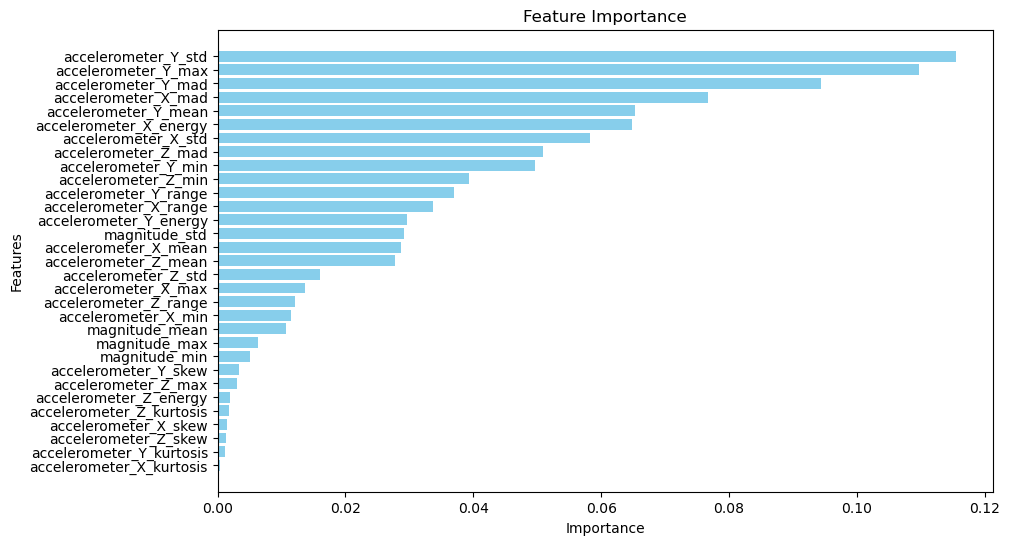

In [291]:
# Отримання важливості ознак
feature_importances = rf_model.feature_importances_

# Створення DataFrame для візуалізації
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Візуалізація
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Перевернути вісь Y для більш зручного читання
plt.show()

## Видалимо найнезначущі ознаки з вибірки

In [294]:
# Видалення ознак із набору даних
low_importance_features = [
    'accelerometer_Y_kurtosis',
    'accelerometer_X_kurtosis',
    'accelerometer_Z_skew',
    'accelerometer_Y_skew',
    'accelerometer_Z_kurtosis',
    'accelerometer_Z_energy'
]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

In [296]:
X_train_reduced.shape[1]

25

In [298]:
rf_reduced_model = RandomForestClassifier(random_state=42).fit(X_train_reduced, y_train)

In [300]:
y_pred_reduced = rf_reduced_model.predict(X_test_reduced)

In [302]:
accuracy_score(y_test, y_pred_reduced)

0.9992266047950503

In [304]:
print(classification_report(y_test, y_pred_reduced, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       1.00      0.97      0.98        33
     walking       1.00      1.00      1.00       370

    accuracy                           1.00      1293
   macro avg       1.00      0.99      1.00      1293
weighted avg       1.00      1.00      1.00      1293



## Залишимо найзначущі 6 ознак

In [307]:
high_importance_features = [
    'accelerometer_Y_std',
    'accelerometer_Y_max',
    'accelerometer_Y_mad',
    'accelerometer_X_mad',
    'accelerometer_Y_mean',
    'accelerometer_X_energy'
]

X_train_6 = X_train[high_importance_features]
X_test_6 = X_test[high_importance_features]
X_train_6.head()

,accelerometer_Y_std,accelerometer_Y_max,accelerometer_Y_mad,accelerometer_X_mad,accelerometer_Y_mean,accelerometer_X_energy
5215,7.530976,9.830592,5.847162,4.226373,-10.843020,768.266610
1752,12.693743,28.064833,10.185956,7.142223,6.126283,4397.961463
4771,4.654908,-2.379836,3.515965,2.866285,-11.292970,820.857139
5159,4.445484,3.586514,3.667257,2.060482,-8.269253,479.108960
3464,15.547119,37.306450,13.517982,8.216900,11.016839,3334.908090


In [309]:
rf_6_model = RandomForestClassifier(random_state=42).fit(X_train_6, y_train)

In [311]:
y_pred_6 = rf_6_model.predict(X_test_6)

In [313]:
accuracy_score(y_test, y_pred_6)

0.9945862335653519

In [315]:
print(classification_report(y_test, y_pred_6, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       1.00      0.79      0.88        33
     walking       0.98      1.00      0.99       370

    accuracy                           0.99      1293
   macro avg       1.00      0.95      0.97      1293
weighted avg       0.99      0.99      0.99      1293



## __Висновок:__
Занадто мала кількість ознак моделі "випадковий ліс" призвела до значного зниження точності передбачення класу stairs.

Проте, якщо видалити 6 найменш значущих ознак, то на точність моделі це майже не вплине

## Алгоритм: SVM

In [323]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0]

array([-0.3926164 , -0.27163614, -0.23722991, -0.50707174, -0.36977964,
       -0.17110653, -0.72758432, -0.22941988, -0.6416097 , -1.54864434,
       -0.15513896, -1.63394197, -0.55544998,  0.3454203 , -0.20394267,
        0.18155089,  0.3064277 ,  0.21049859, -1.02317466,  0.51880711,
       -1.55133094, -0.56117363,  0.73250148,  0.57175184, -0.09766914,
       -1.14590148,  0.04557827, -0.02948303, -0.12267466,  0.06115995,
       -0.58000765])

## Ядро "linear"

In [326]:
svm_linear_model = SVC(kernel='linear', random_state=42).fit(X_train_scaled, y_train)

In [328]:
y_pred = svm_linear_model.predict(X_test_scaled)
print(f"Точність моделі SVM: {accuracy_score(y_test, y_pred)}")
print("Звіт про класифікацію:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Точність моделі SVM: 0.9907192575406032
Звіт про класифікацію:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       0.82      0.82      0.82        33
     walking       0.98      0.98      0.98       370

    accuracy                           0.99      1293
   macro avg       0.95      0.95      0.95      1293
weighted avg       0.99      0.99      0.99      1293



## Ядро "RBF"

In [331]:
svm_rbf_model = SVC(kernel='rbf', random_state=42).fit(X_train_scaled, y_train)

In [333]:
y_pred = svm_rbf_model.predict(X_test_scaled)
print(f"Точність моделі SVM: {accuracy_score(y_test, y_pred)}")
print("Звіт про класифікацію:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Точність моделі SVM: 0.9922660479505027
Звіт про класифікацію:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       0.93      0.76      0.83        33
     walking       0.98      0.99      0.99       370

    accuracy                           0.99      1293
   macro avg       0.98      0.94      0.95      1293
weighted avg       0.99      0.99      0.99      1293



## Оптимізація гіперпараметрів

In [336]:
c_range = np.logspace(-0, 4, 8)
gamma_range = np.logspace(-4, 0, 8)
tuned_parameters = [
    {
        'kernel': ['rbf'],
        'C': c_range,
        'gamma': gamma_range
    },
    {
        'kernel': ['linear'],
        'C': c_range,
        'gamma': gamma_range
    }
]
svc = SVC()
clf = GridSearchCV(
    svc,
    param_grid=tuned_parameters,
    verbose=20,
    cv=4,
    scoring='explained_variance'
)
clf.fit(X_train_scaled, y_train)
print('Best score for data:', clf.best_score_)
print('Best C:', clf.best_estimator_.C)
print('Best Kernel:', clf.best_estimator_.kernel)
print('Best Gamma:', clf.best_estimator_.gamma)

Fitting 4 folds for each of 128 candidates, totalling 512 fits
[CV 1/4; 1/128] START C=1.0, gamma=0.0001, kernel=rbf...........................
[CV 1/4; 1/128] END C=1.0, gamma=0.0001, kernel=rbf;, score=0.973 total time=   0.4s
[CV 2/4; 1/128] START C=1.0, gamma=0.0001, kernel=rbf...........................
[CV 2/4; 1/128] END C=1.0, gamma=0.0001, kernel=rbf;, score=0.978 total time=   0.3s
[CV 3/4; 1/128] START C=1.0, gamma=0.0001, kernel=rbf...........................
[CV 3/4; 1/128] END C=1.0, gamma=0.0001, kernel=rbf;, score=0.978 total time=   0.3s
[CV 4/4; 1/128] START C=1.0, gamma=0.0001, kernel=rbf...........................
[CV 4/4; 1/128] END C=1.0, gamma=0.0001, kernel=rbf;, score=0.978 total time=   0.3s
[CV 1/4; 2/128] START C=1.0, gamma=0.0003727593720314938, kernel=rbf............
[CV 1/4; 2/128] END C=1.0, gamma=0.0003727593720314938, kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/4; 2/128] START C=1.0, gamma=0.0003727593720314938, kernel=rbf............
[CV 2/4; 2/

In [337]:
svm_best_model = clf.best_estimator_

In [338]:
y_pred = svm_best_model.predict(X_test_scaled)
print(f"Точність моделі SVM: {accuracy_score(y_test, y_pred)}")
print("Звіт про класифікацію:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Точність моделі SVM: 0.9992266047950503
Звіт про класифікацію:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       1.00      0.97      0.98        33
     walking       1.00      1.00      1.00       370

    accuracy                           1.00      1293
   macro avg       1.00      0.99      1.00      1293
weighted avg       1.00      1.00      1.00      1293



## __Висновок:__
Лінійна модель svm зі стандартними параметрами добре справляється з класами idle, running, walking, проте не дуже добре з розпізнаванням класу stairs (82%). Скоріш за все це пов'язано з малою кількістю прикладів у датасеті.

rbf модель svm зі стандартними параметрами має трішки кращий результат, але проблема залишається такою ж, досі не дуже добре розпізнає клас stairs (83%).

Після виконання оптимізації гіперпараметрів з крос валідацією, в цілях знайти найкраще ядро серед лінійного та rbf, знайти найкращі гіперпараметри: параметри регуляризації та gamma, знайшлась найкраща модель з такими гіперпараметрами: 
- C: 193.06977288832496
- Kernel: rbf
- Gamma: 0.0193069772888324

з загальною точністю розпізнавання класів 0.9993221532318642 і точністю розпізнавання класу stairs: 98%, так як усі інші класи модель розпізнає правильно зі 100% точністю.

Отже, завдяки рішенню автоматично оптимізувати гіперпараметри, ми знайшли модель з найкращими гіперпараметрами, яка передбачує клас правильно у випадках 99,9%

## Порівняння моделі svm з випадковим лісом.

Модель випадковий ліс виявилася дуже простою у виборі гіперпараметрів та швидкою у навчанні, крім того ми видалили 6 найменш значущих ознак, щоб покращити ефективність роботи моделі і на точність передбачень це майже не вплинуло. Фінальна модель випадкового лісу (де виключено 6 найменш важливих ознак) мала загальну точність розпізнавання класів 0.9992266047950503 і точність розпізнавання усіх класів окремо: клас stairs = 98%, інші класи = 100%.

Модель svm виявилася складною у пошуках оптимальних гіперпараметрів та повільною у навчанні, яке зайняло достатньо багато часу, щоб знайти найкращі гіперпараметри. Фінальна модель svm мала загальну точність розпізнавання класів 0.9993221532318642 і точність розпізнавання усіх класів окремо: клас stairs = 98%, інші класи = 100%.

Тобто, можна вважати, що модель випадковий ліс виявилася кращим варіантом для навчання через її легкість підбору гіперпараметрів та швидкість навчання, проте для швидкості передбачення, краще підходить модель svm, тому що рішення знаходиться меншими об'ємами обчислень, ніж у випадковому лісі, а результат точності передбачень виявився приблизно однаковим для обох моделей.